# Week 4 Peer Graded Assignment: NLP Disaster Tweets Kaggle Mini-Project

## Project Introduction - Description of the Problem

In this project, I'll be using natural language processing (NLP) to analyze tweets. I'm going determine if  the tweets are about real disasters or not. My goal is to create a model that can hopefully be quick and accurate at making these predictions. NLP is about trying to get the computer to understand human language. In this case, I want the computer to understand the tweets. 

Twitter is a social media platform that people tend to use to share quick thoughts with the rest of the world. It's geared towards sharing things quickly since it has certain limitations like number of characters allowed in a tweet so it's a fairly reliable place to communicate with others and get real time updates, espeically in emergency situations. I think a lot of breaking news first tends to start at Twitter and many organizations have twitter accounts there and can share out info on new disasters that pop up.

## Data Overview

For this project, we're using a dataset that comes from Kaggle. Here's the link to it: https://www.kaggle.com/competitions/nlp-getting-started/data

The data is split into a training and test data set. There are 7,613 samples in the training set, and 3,263 sample in the test set. The labels of the training set are 1 if the tweet is about a real disaster and 0 if it's not about a disaster. My goal is to train a model to be able to accurately predict if the tweets in the test set are about a real disaster or not a disaster. 

## Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense, Dropout, LSTM, Bidirectional, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.initializers import Constant

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [5]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_df.info()
test_df.info()
train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Above are the features that are present in my datasets. Additionally, For the training set, there are 61 missing values for keyword, and 2,533 missing values for location since we can see that only 5080 of the 7613 rows showed up as non-null when I looked at the info

In [10]:
print("In training dataset, the # of missing values for keyword: ", sum(train_df['keyword'].isnull()))
print("In the training set, the # of missing values for location: ", sum(train_df['location'].isnull()))

In training dataset, the # of missing values for keyword:  61
In the training set, the # of missing values for location:  2533


Text(0.5, 1.0, 'Distribution of labels in the training data')

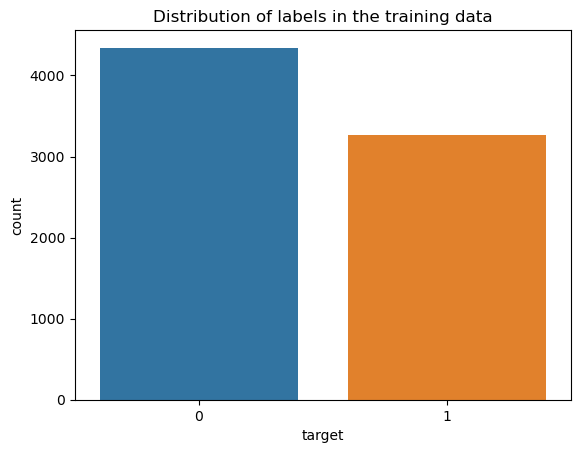

In [11]:
y = train_df['target']
sns.countplot(data=train_df, x='target')
plt.title("Distribution of labels in the training data")

The distribution of labels is even but it's also not super skewed. I don't expect this uneven distribution to cause to many problems when modeling the data. The next thing I wanted to look at were the frequencies of the keywords and locations incase it's potentially useful for the model. I'm also checking to see if the keyword is included in the text.

Number of unique keywords: 221


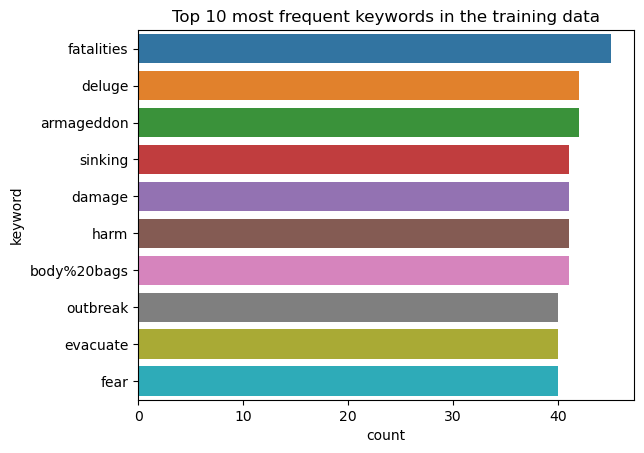

In [12]:
keywords = train_df[['keyword', 'location']]
sns.countplot(data=keywords, order=keywords['keyword'].value_counts().iloc[:10].index, y='keyword')
plt.title("Top 10 most frequent keywords in the training data")
print("Number of unique keywords:", keywords['keyword'].nunique())

In [14]:
train_df['keyword_in_text'] = train_df.apply(lambda row: int(row['keyword'] in row['text'].lower() if pd.notnull(row['keyword']) else False), axis=1)
print("Rows with keyword in text:", len(train_df[train_df['keyword_in_text'] == 1]))
print("Rows without keyword in text:", len(train_df[train_df['keyword_in_text'] == 0]))

Rows with keyword in text: 5973
Rows without keyword in text: 1640


Based on the EDA, there are 221 unique keywords in the dataset. I looked at my graph and it looks like the frequency of the keywords isn't too significant since even the most common keyword only shows up around 45 times. In the training dataset, there were 5973 rows that had the keyboards within the text, but there were another 1640 that didn't have the keyword in the text. I did further research and I think the keyword might not be perfect in properly identifing a disaster sometimes, so I might not include it in my model.

I looked into the location feature. There are 3,341 distinct locations in the dataset. USA makes up a lot of the top locations. It doesn't seem that useful to include in the model either. USA is also a huge location in comparison to some of the cities and countries mentioned in the top 10 list also, so it might not be that helpful. 

Number of unique locations: 3341


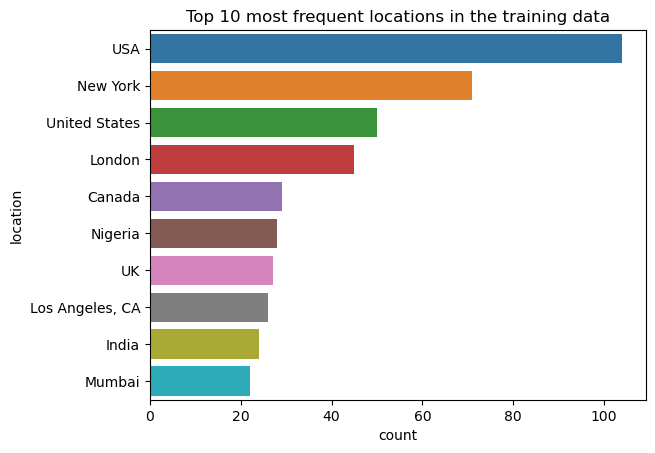

In [15]:
sns.countplot(data=keywords, order=keywords['location'].value_counts().iloc[:10].index, y='location')
plt.title("Top 10 most frequent locations in the training data")
print("Number of unique locations:", keywords['location'].nunique())

Another thing I want to look at is a distribution comparing the word count, character count, and length of words between tweets about disasters and non-disasters.

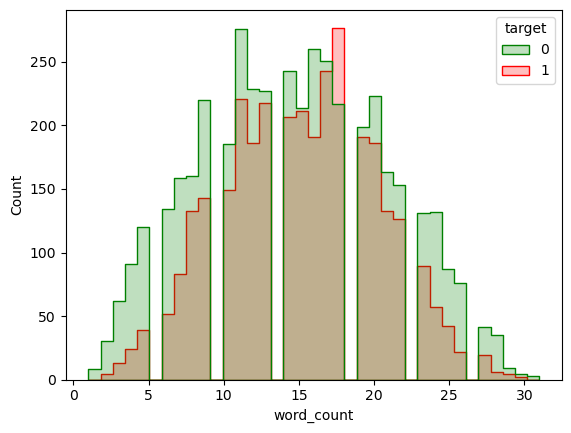

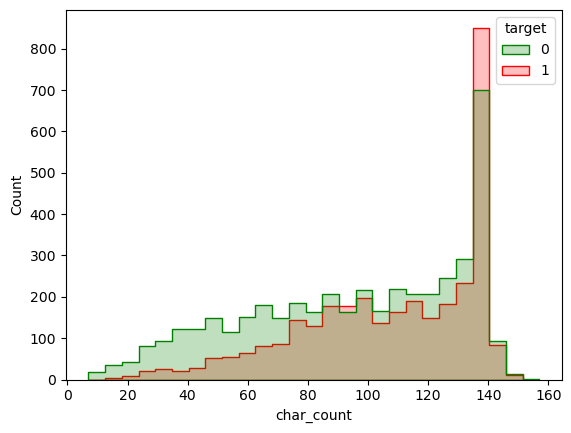

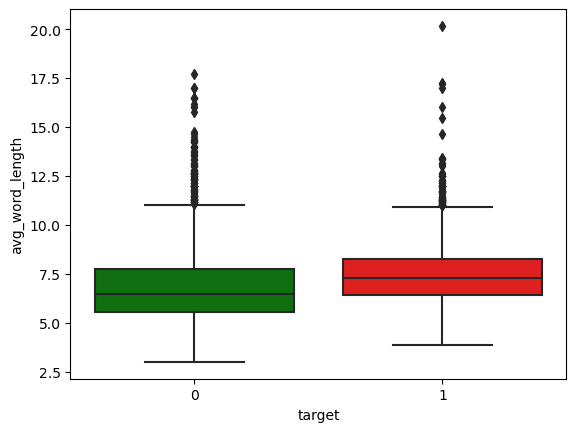

In [18]:
train_df['word_count'] = train_df['text'].str.split().str.len()
train_df['char_count'] = train_df['text'].str.len()
train_df['avg_word_length'] = train_df.apply(lambda row: row['char_count']/row['word_count'], axis=1)
sns.histplot(data=train_df, x='word_count', hue='target', element='step', palette=["green", "red"])
plt.show()
sns.histplot(data=train_df, x='char_count', hue='target', element='step', palette=["green", "red"])
plt.show()
sns.boxplot(data=train_df, x='target', y='avg_word_length', palette=["green", "red"])
plt.show()

The word count for both categories, disaster and non-disaster tweets, appears to be quite similar. However, it looks like the tweets about real disasters seems to havea a higher average character count and longer average word lengths. I think this might be because tweets on disasters are coming from news organizations and they like to use jargon that's usually longer and more formal sounding. I think these features might have some value in my model.

# Data Preprocessing and My Plan of Analysis

There's a couple things I want to take care of in the dataset before we build a model from it. I am going to dealing with punctuation, special characters, any symbols and other references that might cause problems with the model. I'm also going to tokenize my dataset so that the computer can understand the data better. 

In [20]:
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Data Preprocessing
def clean_text(df, clean_level=0):
    df1 = df.copy()
    df1['text'] = df1['text'].str.lower()
    if clean_level == 0:
        df1['text'] = df1['text'].apply(lambda x: re.sub(r"([!@#$%^&*()|;,./?><])", " \\1 ", x))
        df1['text'] = df1['text'].str.replace("'", "")
    else:
        df1['text'] = df1['text'].apply(lambda x: re.sub(r'http\S+', '', x))
        df1['text'] = df1['text'].apply(lambda x: re.sub(r"([!@#$%^&*()|;,./?><\'])", "", x))
        emojis = re.compile("["
            u"\U0001F600-\U0001F64F" 
            u"\U0001F300-\U0001F5FF" 
            u"\U0001F680-\U0001F6FF"  
            u"\U0001F1E0-\U0001F1FF"  
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            "]+", flags=re.UNICODE)
        df1['text'] = df1['text'].apply(lambda x: re.sub(emojis, '', x))
    return df1

train_data1 = clean_text(train_df)
test_data1 = clean_text(test_df)
train_data_clean = clean_text(train_df, 1)
test_data_clean = clean_text(test_df, 1)

def create_sequences(df, tokenizer, seq_length):
    sequences = tokenizer.texts_to_sequences(df['text'])
    pad_seq = pad_sequences(sequences, maxlen=seq_length)
    return pad_seq

def prepare_embeddings(filepath, word_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    with open(filepath, 'r', encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data1['text'])
word_index = tokenizer.word_index

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(train_data_clean['text'])
word_index2 = tokenizer2.word_index

filepath = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
embedding_dim = 100
embedding_matrix_vocab = prepare_embeddings(filepath, word_index, embedding_dim)
embedding_matrix_vocab2 = prepare_embeddings(filepath, word_index2, embedding_dim)

seq_length = max(len(s) for s in tokenizer.texts_to_sequences(train_data1['text']))
seq_length2 = max(len(s) for s in tokenizer2.texts_to_sequences(train_data_clean['text']))

pad_seq = create_sequences(train_data1, tokenizer, seq_length)
pad_seq_test = create_sequences(test_data1, tokenizer, seq_length)

pad_seq2 = create_sequences(train_data_clean, tokenizer2, seq_length2)
pad_seq_test2 = create_sequences(test_data_clean, tokenizer2, seq_length2)

# Building Model
I'm going to be building a Recurrent Neural Network (RNN) model and a LSTM model.

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
input_dim = len(word_index) + 1
output_dim = embedding_dim
input_length = seq_length
model = Sequential()
model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length,
                    weights=[embedding_matrix_vocab], trainable=False))
model.add(SimpleRNN(units=32, return_sequences=False))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(pad_seq, train_df['target'], epochs=5, batch_size=32, validation_split=0.2)
predictions = model.predict(pad_seq_test)
binary_predictions = (predictions > 0.5).astype(int).flatten()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 33, 100)           2208400   
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                4256      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,212,689
Trainable params: 4,289
Non-trainable params: 2,208,400
_________________________________________________________________
Epoch 1/5
191/191 [==============================] - 4s 12ms/step - loss: 0.6410 - accuracy: 0.6358 - val_loss: 0.5460 - val_accuracy: 0.7492
Epoch 2/5
191/191 [==============================] - 2s 10ms/step - loss: 0.5050 - accuracy: 0.7768 - val_loss: 0.4919 - val_accuracy: 0.7833
Epoch 3/5
191/191 [=

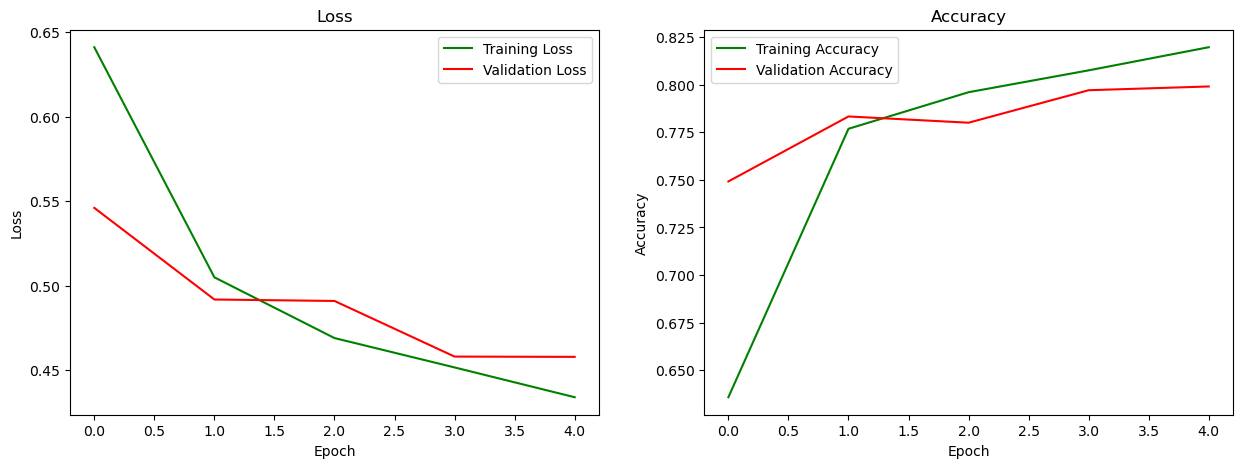

In [39]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_loss, color = 'green', label='Training Loss')
ax1.plot(val_loss, color = 'red', label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_acc, color = 'green', label='Training Accuracy')
ax2.plot(val_acc, color = 'red', label='Validation Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 33, 100)           2208400   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,250,705
Trainable params: 42,305
Non-trainable params: 2,208,400
_________________________________________________________________
Epoch 1/5
191/191 [==============================] - 8s 28ms/step - loss: 0.5020 - accuracy: 0.7614 - val_loss: 0.4243 - val_accuracy: 0.8116
Epoch 2/5
191/191 [==============================] - 5s 24ms/step - loss: 0.4309 - accuracy: 0.8113 - val_loss: 0.4624 - val_accuracy: 0.7768
Epoch 3/5
191/191 [

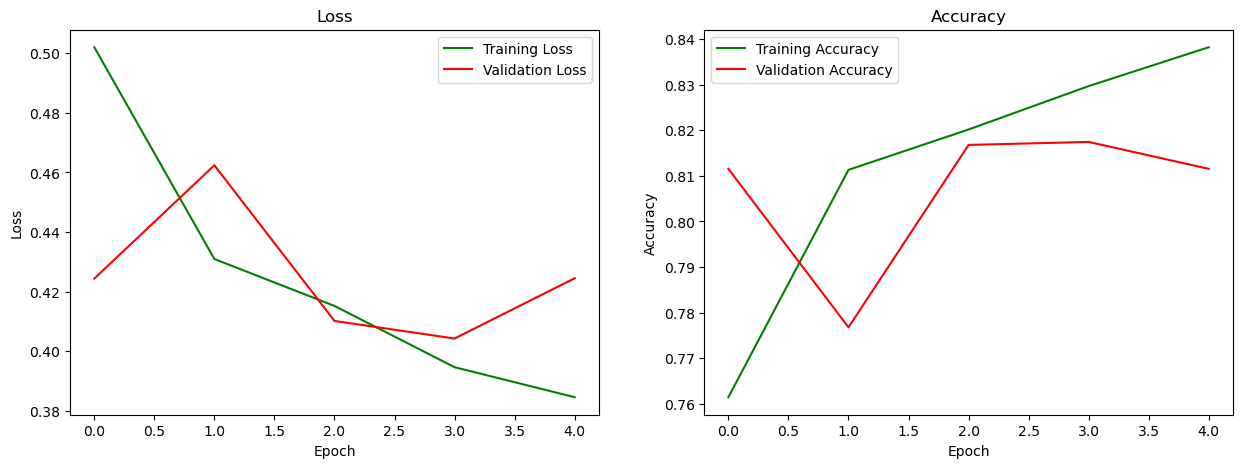

In [42]:
from tensorflow.keras.layers import LSTM
hidden_units = 64
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length,
                    weights=[embedding_matrix_vocab], trainable=False))
lstm_model.add(LSTM(units=hidden_units, return_sequences=False))
lstm_model.add(Dense(units=1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()
lstm_history = lstm_model.fit(pad_seq, train_df['target'], epochs=5, batch_size=32, validation_split=0.2)
train_loss = lstm_history.history['loss']
val_loss = lstm_history.history['val_loss']
train_acc = lstm_history.history['accuracy']
val_acc = lstm_history.history['val_accuracy']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_loss, color = 'green', label='Training Loss')
ax1.plot(val_loss, color = 'red', label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(train_acc, color = 'green', label='Training Accuracy')
ax2.plot(val_acc, color = 'red', label='Validation Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [43]:
print("Baseline RNN Model - Validation Loss:", history.history['val_loss'][-1])
print("Baseline RNN Model - Validation Accuracy:", history.history['val_accuracy'][-1])
print("Updated LSTM Model - Validation Loss:", lstm_history.history['val_loss'][-1])
print("Updated LSTM Model - Validation Accuracy:", lstm_history.history['val_accuracy'][-1])

Baseline RNN Model - Validation Loss: 0.4579392373561859
Baseline RNN Model - Validation Accuracy: 0.7990807890892029
Updated LSTM Model - Validation Loss: 0.4244541823863983
Updated LSTM Model - Validation Accuracy: 0.8115561604499817


## Results, Analysis, and Conclusion

For my project, I trained two different recurrent neural network models to predict the target variable using the twitter text data. I first built a baseline simple recurrent neural network (RNN) modle and then I build a long short term memory (LSTM) model. I then evaluated the performance of both models. 

For the baseline RNN model, i got a validation loss value of around 0.4579. THe validation accuracy for the model was around 79.91%. The updated long short term memory model did a little better than the baseline model in terms of performance. The validation loss fo rthe LSTM model was reduced a little to around 0.4245. On top of that, the validation accuracy increased to around 81.16%. 

Based on the results, I am concluding that the long short term memory model outperformed my baseline RNN model for both, the validation accuracy and loss. I think the LSTM model did better because of its ability to retail and process long term dependencies in the data, so I think its just a more applicable model for this particular model compared to the base RNN model. If I were to iterate on this project some more, I would continue to fine tune the hyperparameters for the LSTM model. I might also try building a bidirectional LSTM model. Another thing I would do is spend more time doing additional feature engineering that might hopefully improve the model performance further. 

Overall, I learned a lot from this project. I was able to see the effeectiveness of the LSTM model on text classification related tasks and I also got to apply my deep learning skills further.